In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random
import glob

In [2]:
# scan data directories

nature_file_list = []
nature_file_list += glob.glob('../data/interim/AmbisonicSoundLibrary/nature/*')
nature_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, rural or natural/*')
nature_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_nature/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/non_urban/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/urban_0_25/*')

city_file_list = []
city_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, urban or manmade/*')
city_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_city/*')
# city_file_list += glob.glob('../data/interim/S2L_LULC/urban_26_100/*')

# these two directories have way too many files, which will biase the training toward the difference between these 2 them rather the category
NS_file_list = glob.glob('../data/interim/youtube/NatureSoundscapes/*')
SONYC_file_list = glob.glob('../data/interim/SONYC/**/*.pkl')

import random
random.seed(23)

# sampling
NS_file_list_sampled = random.sample(NS_file_list, 1000)
nature_file_list += NS_file_list_sampled

SONYC_file_list_sampled = random.sample(SONYC_file_list, len(nature_file_list)-len(city_file_list)) # compensate the difference
city_file_list += SONYC_file_list_sampled 

# # use all files
# nature_file_list += NS_file_list
# city_file_list += SONYC_file_list

nature_source_list = ['nature_'+i.rsplit('/', 3)[1]+'/'+i.rsplit('/', 3)[2] for i in nature_file_list]
city_source_list = ['city_'+i.rsplit('/', -1)[3] for i in city_file_list]

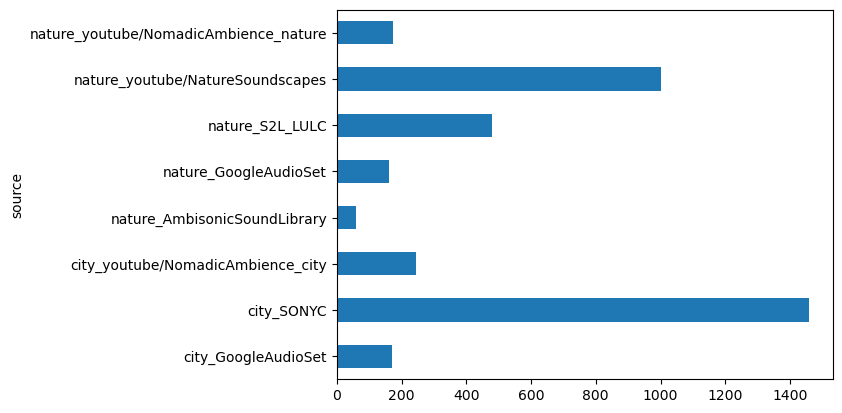

In [3]:
# sorting out the sources of data files
nature_df = pd.DataFrame({'file': nature_file_list, 'source': nature_source_list, 'category': 0})
city_df = pd.DataFrame({'file': city_file_list, 'source': city_source_list, 'category': 1})
df_all = pd.concat([nature_df, city_df], ignore_index=True)

df_all['source'] = df_all['source'].str.replace('nature_AmbisonicSoundLibrary/nature','nature_AmbisonicSoundLibrary')
df_all['source'] = df_all['source'].str.replace('nature_GoogleAudioSet/Outside, rural or natural','nature_GoogleAudioSet')
df_all['source'] = df_all['source'].str.replace('city_youtube','city_youtube/NomadicAmbience_city')
df_all['source'] = df_all['source'].str.replace('nature_S2L_LULC/urban_0_25','nature_S2L_LULC')
df_all['source'] = df_all['source'].str.replace('nature_S2L_LULC/non_urban','nature_S2L_LULC')


source_count = df_all.groupby(['source'])['file'].count()
ax = source_count.plot.barh()
plt.show()

In [4]:
# make the weights as the inverse of the number of files per source
df_all['weight'] = df_all['source'].apply(lambda s: 1/source_count.loc[s])

# make the samples in the GoogleAudioSet to be ? times, as they were all from different sources
extra_weight = 10
df_all.loc[df_all['source'].str.contains('GoogleAudioSet'),'weight'] = df_all.loc[df_all['source'].str.contains('GoogleAudioSet'),'weight']*extra_weight
df_all.groupby(['source'])['weight'].sum()

# just set all the weights to 1
df_all['weight'] = 1

In [5]:
# extract the youtube ID of the file out and put it as 'file_group'
df_all['file_group'] = df_all['file'].apply(lambda st: st[st.find('/youtube/')+1:st.rfind("_")])

# for the rows that were not extracted from youtube, replace the 'file_group' by 'file', as they are all from different sources
df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file_group'] = df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file']
df_all

,file,source,category,weight,file_group
0,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary,0,1,../data/interim/AmbisonicSoundLibrary/nature/W...
1,../data/interim/AmbisonicSoundLibrary/nature/R...,nature_AmbisonicSoundLibrary,0,1,../data/interim/AmbisonicSoundLibrary/nature/R...
2,../data/interim/AmbisonicSoundLibrary/nature/A...,nature_AmbisonicSoundLibrary,0,1,../data/interim/AmbisonicSoundLibrary/nature/A...
3,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary,0,1,../data/interim/AmbisonicSoundLibrary/nature/W...
4,../data/interim/AmbisonicSoundLibrary/nature/L...,nature_AmbisonicSoundLibrary,0,1,../data/interim/AmbisonicSoundLibrary/nature/L...
...,...,...,...,...,...
3741,../data/interim/SONYC/audio-3/46_011558.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-3/46_011558.pkl
3742,../data/interim/SONYC/audio-9/09_027851.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-9/09_027851.pkl
3743,../data/interim/SONYC/audio-13/41_008825.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-13/41_008825.pkl
3744,../data/interim/SONYC/audio-9/41_011975.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-9/41_011975.pkl


In [6]:
from sklearn.model_selection import StratifiedGroupKFold

# Split the data into folds using StratifiedKFold
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=23)
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=df_all, y=df_all['source'], groups=df_all['file_group'])):
    # Assign the fold number to each row in the DataFrame
    df_all.loc[val_idx, 'fold'] = fold
    
df_all['fold'] = df_all['fold'].astype('int')

# need to shuffle the rows before deep learning
df_all = df_all.sample(frac=1, random_state=23).reset_index(drop=True) 
df_all

,file,source,category,weight,file_group,fold
0,../data/interim/SONYC/audio-10/20_011429.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-10/20_011429.pkl,5
1,../data/interim/youtube/NatureSoundscapes/vhRf...,nature_youtube/NatureSoundscapes,0,1,youtube/NatureSoundscapes/vhRfoycmg68,5
2,../data/interim/SONYC/audio-4/02_009415.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-4/02_009415.pkl,1
3,../data/interim/SONYC/audio-11/10_011701.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-11/10_011701.pkl,1
4,"../data/interim/GoogleAudioSet/Outside, rural ...",nature_GoogleAudioSet,0,1,"../data/interim/GoogleAudioSet/Outside, rural ...",5
...,...,...,...,...,...,...
3741,../data/interim/SONYC/audio-15/32_009631.pkl,city_SONYC,1,1,../data/interim/SONYC/audio-15/32_009631.pkl,5
3742,"../data/interim/GoogleAudioSet/Outside, urban ...",city_GoogleAudioSet,1,1,"../data/interim/GoogleAudioSet/Outside, urban ...",3
3743,../data/interim/youtube/NatureSoundscapes/fpPF...,nature_youtube/NatureSoundscapes,0,1,youtube/NatureSoundscapes/fpPF-uoLaCE,0
3744,../data/interim/S2L_LULC/urban_0_25/s2lam051_2...,nature_S2L_LULC,0,1,../data/interim/S2L_LULC/urban_0_25/s2lam051_2...,4


In [7]:
# df_all.to_csv('../train_val_test_sgkf_Feb24_shorter.csv')
df_all.to_csv('../train_val_test_sgkf_Feb24_no_weight.csv')